In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import datetime
from iautils import cascade

from datetime import datetime
from astropy.coordinates import SkyCoord

/opt/pysetup/.venv/lib/python3.11/site-packages/chime_frb_api/__init__.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution as _get_distribution


In [2]:
sys.path.append("/arc/home/mseth/.local/lib/python3.11/site-packages")
import memory_profiler



%load_ext memory_profiler

In [3]:
%matplotlib inline

In [4]:
sys.path.insert(0, os.path.abspath('beam-model'))
from beam_model import utils, formed

Stuff we define beforehand

In [5]:
freqs = np.linspace(400.390625, 800, 16384)          # The data has 16384 frequency channels
freqs_2 = np.linspace(400.390625, 800, 1024)         # The holography data has 1024 frequency channels
has = np.array(np.linspace(-105, 104.90278, 2160))   # 2160 HAs

source_name = "TAU_A"
coords = SkyCoord.from_name(source_name)
source_ra = coords.ra.deg
source_dec = coords.dec.deg


# BF to JY conversion equation
def bf_to_jy(bf_spectrum, f_good):
    factor = (np.square(1024) * 128) / (np.square(4) * 0.806745 * 400)
    result = bf_spectrum / ( factor * np.square(f_good) ) 
    return result

Data

In [6]:
data = np.load("/arc/projects/chime_frb/mseth/Crab_data_56_a.npz", allow_pickle=True)

dms = data['DM']
max_tidxs = data['MAX_TIDX']
max_timestamps = data['MAX_TIMESTAMP']
has_at_peak = data['HA']
y_at_peak = data['Y']
beam_ids_string = data['BEAM_ID']

beam_ids = []
for beam_id in beam_ids_string:
    beam_id_int = int(beam_id)
    beam_ids.append(beam_id_int)

spectra = np.load("/arc/projects/chime_frb/mseth/Crab_spectra_56_a.npz")

spectra_at_peak = spectra['SPECTRUM']

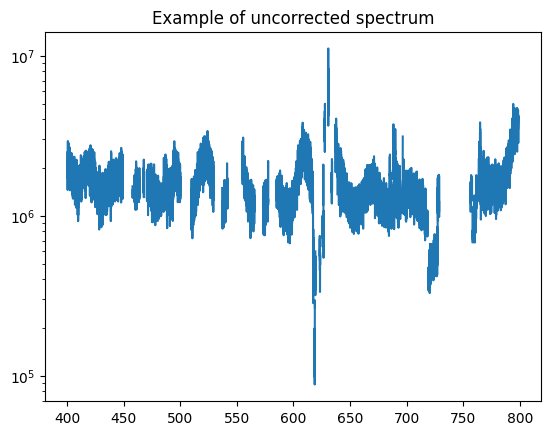

In [7]:
plt.figure()
plt.plot(freqs, spectra_at_peak[0])
plt.yscale('log')
plt.title("Example of uncorrected spectrum")
plt.show()

Beams & Correcting

In [8]:
## PRIMARY BEAM RESPONSE ##

# Load in holography data 
path = "/arc/projects/chime_frb/mseth/holography_data"

npz_files = []
for (root, dirs, file) in os.walk(path):
    for f in file: 
        npz_files.append(os.path.join(root, f))
        
xx_list = []
yy_list = []
for file in npz_files:
    data = np.load(file)
    xx = data['XX']
    yy = data['YY']
    xx_list.append(xx)
    yy_list.append(yy)

xx = np.vstack(xx_list)
yy = np.vstack(yy_list)

intensity = xx + yy / 2
intensity_masked = intensity[:,1760:1840]
intensity_max = np.max(intensity_masked)
intensity_norm = intensity / intensity_max

/tmp/ipykernel_3111/699488280.py:9: RuntimeWarning: divide by zero encountered in log10
  pcm = ax['A'].pcolormesh(has, freqs_2, np.log10(intensity_norm))


<Figure size 640x480 with 0 Axes>

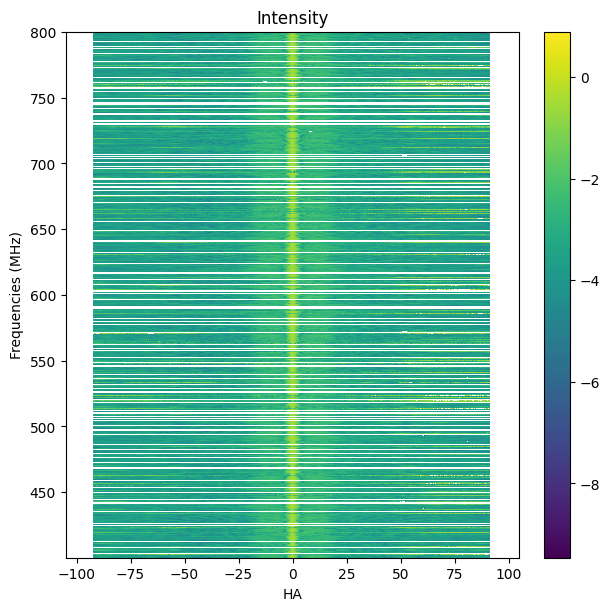

In [9]:
plt.figure()
fig, ax = plt.subplot_mosaic(
    '''
    AA
    ''',
    figsize = (6,6),
    layout = 'constrained')

pcm = ax['A'].pcolormesh(has, freqs_2, np.log10(intensity_norm))
ax['A'].set_ylabel('Frequencies (MHz)')
ax['A'].set_xlabel('HA')
ax['A'].set_title('Intensity')

fig.colorbar(pcm, ax=ax['A'])

plt.show()

In [10]:
xx.shape

(1024, 2160)

In [11]:
intensity_norm.shape

(1024, 2160)

In [12]:
# Get spectra at every peak HA 
presponse_norm = []

for ha in has_at_peak:
    idx = (np.abs(has - ha)).argmin()              # Find index of closest HA to HA at peak
    xx_response = xx[:,idx]
    yy_response = yy[:, idx]
    
    int_response = intensity_norm[:,idx]           # Get intensity spectrum at that HA 
    int_response[int_response==0] = np.nan
    presponse_norm.append(int_response)

In [13]:
## CORRECTING FOR PRIMARY BEAM RESPONSE ##

p_corrected_sp = []

for i, (spectra, presponse) in enumerate(zip(spectra_at_peak, presponse_norm)):
    downsampled_spectra = spectra[::16]                           # Downsample data from 16384 freq channels to 1024 (to match holography
    spectra_at_peak_corrected = downsampled_spectra / presponse   # Correction
    p_corrected_sp.append(spectra_at_peak_corrected)

In [14]:
## SYNTHESIZED BEAM RESPONSE + CORRECTING

sbm = formed.FFTFormedSincBeamModel()

calibrated_spectra = []

for i, (beam_id, ha, y, spectrum) in enumerate(zip(beam_ids, has_at_peak, y_at_peak, p_corrected_sp)):
    sensitivity = sbm.get_sensitivity(beam_id, np.array([ha, y]).T, freqs_2).squeeze()
    
    mean_sensitivity = np.nanmean(sensitivity)            # Average sensitivity across frequencies
    peak_sensitivity_ind = np.argmax(mean_sensitivity)            
    sensitivity_at_peak = sensitivity[peak_sensitivity_ind]    # Spectrum of synthesized response at its peak

    spectra_corrected = spectrum / sensitivity_at_peak            # Correction
    spectra_jy = bf_to_jy(spectra_corrected, 1)                   # Conversion
    calibrated_spectra.append(spectra_jy)

In [15]:
mean_fluxes = []

for calibrated_spectrum in calibrated_spectra:
    mean = np.nanmean(calibrated_spectrum)
    mean_fluxes.append(mean)

In [16]:
mean_fluxes

[1121687832205.0056,
 536222147.3534351,
 280283139224.32556,
 2256157179188.247,
 24656992705.41428,
 8282696247852.858,
 3.5282452958388314e+19,
 282726848665.928,
 86183637442282.05,
 224440465230852.03,
 18435431943913.63,
 777350185.357396,
 3610489961346.882,
 491954540277.0261,
 9640807620.537743,
 995147016347.0468,
 1993078372205.9478,
 1164495945544.52,
 2469346303845.7925]

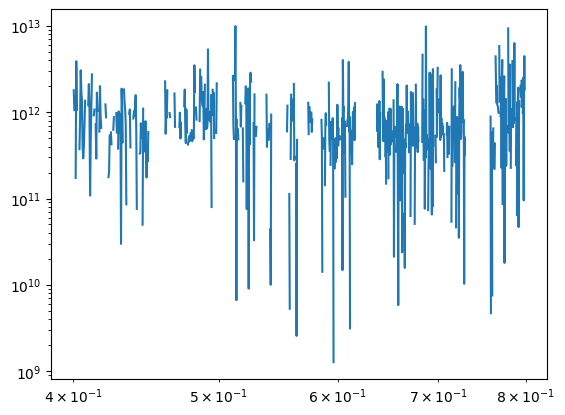

In [19]:
plt.figure()
plt.plot(freqs_2/1000, calibrated_spectra[15])
plt.yscale('log')
plt.xscale('log')
plt.show()